In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy import interpolate
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d

In [2]:
def my_plot_style():
    params = {'legend.fontsize': 15,
    'axes.labelsize': 15,
    'axes.titlesize':15,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'xtick.major.size':5,
    'xtick.minor.size':2.5,
    'ytick.major.size':5,
    'ytick.minor.size':2.5,
    'figure.facecolor':'w',
    #'lines.linewidth' : 1.5,
    'xtick.major.width':1.5,
    'ytick.major.width':1.5,
    'xtick.minor.width':1.5,
    'ytick.minor.width':1.5,
    'axes.linewidth':1.5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'ytick.labelleft':True,
    'text.usetex' : False,
    'font.family': 'sans-serif'}
    plt.rcParams.update(params)
my_plot_style()

##  Activity 1: 
For the first in-class activity we will be making our own highly simplified version of HR diagrams, PDMF, and mass-to-light ratio diagrams for simple stellar populations. The simplification we will make, which is a bad one, is to neglect post-main sequence stars.
#### 1. First, write a function that interpolates the main sequence mass to Teff, luminosity, and lifetime relations given in the main-sequence star scaling relation file.

In [54]:
scaling = Table.read('MS_star_scaling_relations.fits')
def mass2quan(mass,quan='Teff'):
    # quan = Teff, luminosity, tau_MS_Gyr
    #return np.interp(mass,scaling['mass'],scaling[quan])
    func = interp1d(scaling['mass'],scaling[quan], fill_value='extrapolate')
    return func(mass)

#### 2. Sample a very large number of stars (enough to ensure you have a few tens of O stars) from a Salpeter IMF (phi ~ m^-2.35; 0.08<m<100)

In [8]:
def cal_cdf(x,fx):
#     binsize = x[1]-x[0]
#     cdf = [np.trapz(fx[:i],dx=binsize) for i in range(1,1+len(x))]
    cdf = np.cumsum(fx)
    return cdf/cdf[-1]
def sample(x,fx,n):
    s    = np.random.uniform(0,1,n)
    cdf  = cal_cdf(x,fx)
    f = interpolate.interp1d(cdf, x, fill_value='extrapolate')
    samp = f(s)
    return samp
def plot_pdf(sample,bins=30,binsize=-1):
    hist, bedge = np.histogram(sample,bins=bins)
    bedges = (bedge[1:]+bedge[:-1])/2.0
    if(binsize<0): binsize = bedge[1]-bedge[0]
    return bedges, hist/np.sum(hist)/binsize

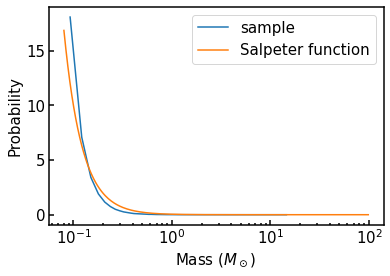

In [32]:
#xrange   = np.arange(0.08,100,0.001)
xrange   = 10**np.arange(np.log10(0.08),2,0.01)
n        = int(1e5)
salpeter = lambda x:x**(-2.35)
pdf      = lambda x:salpeter(x)/np.trapz(salpeter(x),x=x)

samp = sample(xrange,pdf(xrange),n)
#plt.semilogx(xrange,cal_cdf(xrange,pdf(xrange)))
#plt.semilogx(xrange,pdf(xrange))

x, y = plot_pdf(samp,bins=500)
plt.semilogx(x,y,label='sample')
plt.semilogx(xrange,pdf(xrange),label='Salpeter function')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Probability')
plt.legend()
plt.show()

#### 3. Using the mass to main sequence scaling relation, make an HR diagram (luminosity vs Teff) for a simple stellar population at ages 0, 0.2, 0.5, 1, 2.5, and 5 Gyr. For each age, plot the total luminosity of the population and both the mean effective temperature and luminosity-weighted mean effective temperature on your HR diagram.

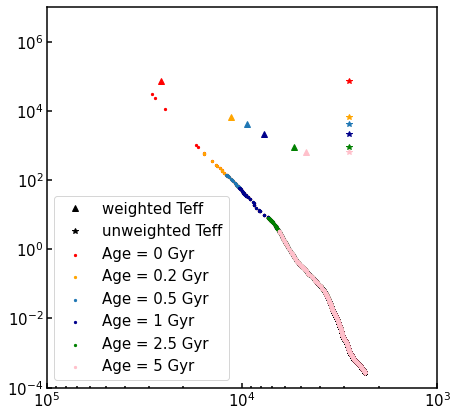

In [40]:
lifetime = mass2quan(samp,'tau_MS_Gyr')
Teff     = mass2quan(samp,'Teff')
lum      = mass2quan(samp,'luminosity')
tot_m2l  = []

ages  = [0,0.2,0.5,1,2.5,5]
colors = ['red','orange','tab:blue','darkblue','green','pink']
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=[7,7])
for i,age in enumerate(ages):
    boolean = lifetime>age
    t, l = Teff[boolean], lum[boolean]
    ax.scatter(t,l,s=5,c=colors[i],label=f'Age = {age} Gyr')
    ax.plot(np.average(t,weights=l),np.sum(l),marker='^',color=colors[i])
    ax.plot(np.average(t),np.sum(l),marker='*',color=colors[i])
    tot_m2l.append(np.sum(samp[boolean])/np.sum(l))
    
ax.set_ylim([1e-4,1e7])
ax.set_xlim([1e5,1e3])
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot([],[],ls='',marker='^',color='black',label='weighted Teff')
ax.plot([],[],ls='',marker='*',color='black',label='unweighted Teff')
ax.legend(loc='lower left')

plt.show()


#### 4. At each age, make a histogram of the present day mass function and compare them.

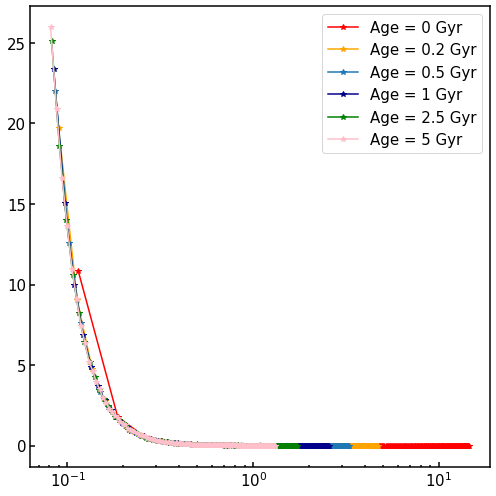

In [41]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=[7,7])
for i in range(6):
    boolean = lifetime>ages[i]
    x, y = plot_pdf(samp[boolean],bins=200)
    ax.plot(x,y,'*-',color=colors[i],label=f'Age = {ages[i]} Gyr')
    ax.set_xscale('log')
#ax.set_xlim([6e-1,1e1])
ax.legend(loc='upper right')
plt.tight_layout()

#### 5. Plot the mass-to-light ratio of the simple stellar populations as a function of age.

Text(0, 0.5, 'Mass-Light ratio')

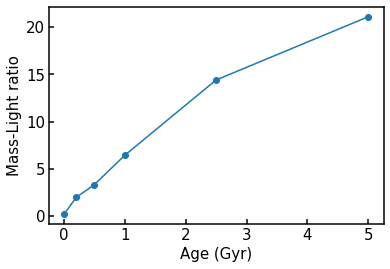

In [42]:
plt.plot(ages,tot_m2l,'-o')
plt.xlabel('Age (Gyr)')
plt.ylabel('Mass-Light ratio')

#### 6. Choose one younger and one older age and make a cumulative plot of mass vs total mass and mass vs total light. Which stars dominate the mass and which stars dominate the light?

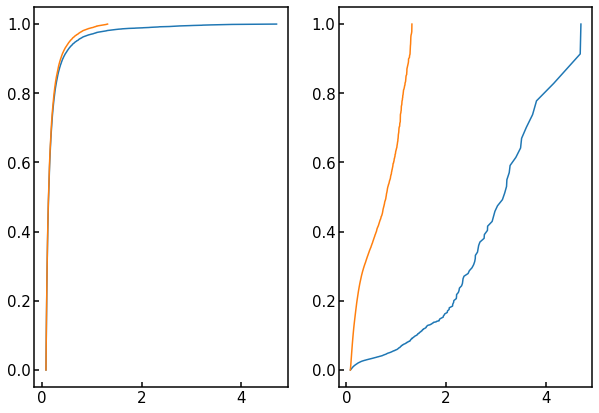

In [48]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[10,7])
yval = [samp,lum]
idx = np.argsort(samp)
cutage = [ages[1],ages[-1]]
for i in range(2):
    ax = axes[i]
    ydata = yval[i]
    for j in range(2):
        boolean = lifetime>cutage[j]
        x = samp[boolean]
        y = ydata[boolean]
        idx = np.argsort(x)
        y = np.cumsum(y[idx])
        y /= y[-1]
        ax.plot(x[idx],y)
    #ax.set_xscale('log')
    #ax.set_xlim([0,4])

## Activity 2
For the second in-class activity, we will make more realistic versions of this using star clusters that include post main sequence stars but with the slight annoyance that it is in the magnitude system (ah well).

#### a. Select likely cluster members from the GAIA catalogs for the three clusters in the Week 2 folder using GAIA coordinates, proper motion, and parallax (if useful). You may want to look at R.A. proper motion and declination proper motion instead of just the total proper motion like we did before. The clusters are: 
Pleiades: DM=5.667, log(age/yr)=8.04, [Fe/H]=-0.01, E(B-V)=0.045 \
NGC 2682: DM=9.726, log(age/yr)=9.54, [Fe/H]=0.03, E(B-V)=0.037 \
NGC 6397: DM=11.92, log(age/yr)=13.5, [Fe/H]=-2.02, E(B-V)=0.18 


In [49]:
root = '../datas/'
pleiades = Table.read(root+'Pleiades_GAIA.fits')
ngc2682  = Table.read(root+'NGC2682_GAIA.fits')
ngc6387  = Table.read(root+'NGC6397_GAIA.fits')
data = [pleiades,ngc2682,ngc6387]
clusters = []
for cluster in data:
    clusters.append(cluster[(~np.isnan(cluster['distance_gspphot']))&(cluster['parallax']>0)])

In [50]:
def select_member(cluster,axis,yaxis,yname):
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,7))
    bool_arr = []
    for i in range(2):
        ax = axes[i]
        
        # Set plotting data and rectangle boundary
        x, y = 'parallax', yaxis[i]
        xlim, ylim = axis['rec_x'][i], axis['rec_y'][i]
        cx, dx = np.mean(xlim), xlim[1]-xlim[0]
        cy, dy = np.mean(ylim), ylim[1]-ylim[0]
        rec = plt.Rectangle([xlim[0],ylim[0]],xlim[1]-xlim[0],ylim[1]-ylim[0],fill=False,color='red')

        ax.scatter(cluster[x],cluster[y],s=0.1)
        ax.add_patch(rec)
        ax.set_xlabel('Parallax (mas)')
        ax.set_ylabel(yname[i])
        ax.set_xlim(axis['plot_x'][i])
        ax.set_ylim(axis['plot_y'][i])
        
        # First select sample by eye
        boolean = (abs(cluster[x]-cx)<dx/2)&(abs(cluster[y]-cy)<dy/2)
        bool_arr.append(boolean)

    # sigma-clipping data in sample
    boolean = bool_arr[0]&bool_arr[1]
    sample = cluster[boolean]
    mask = sigma_clip(sample['distance_gspphot'],sigma=3).mask
    sample = sample[~mask]
    for i in range(2):
        axes[i].scatter(sample['parallax'],sample[yaxis[i]],s=1)
    plt.show()
    return sample

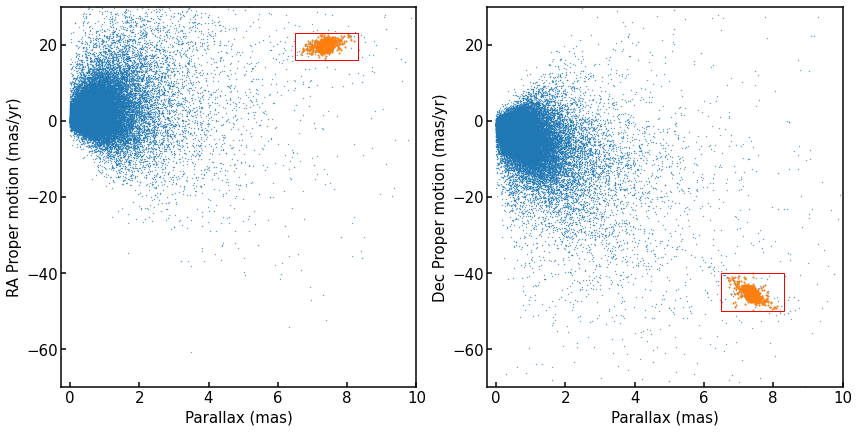

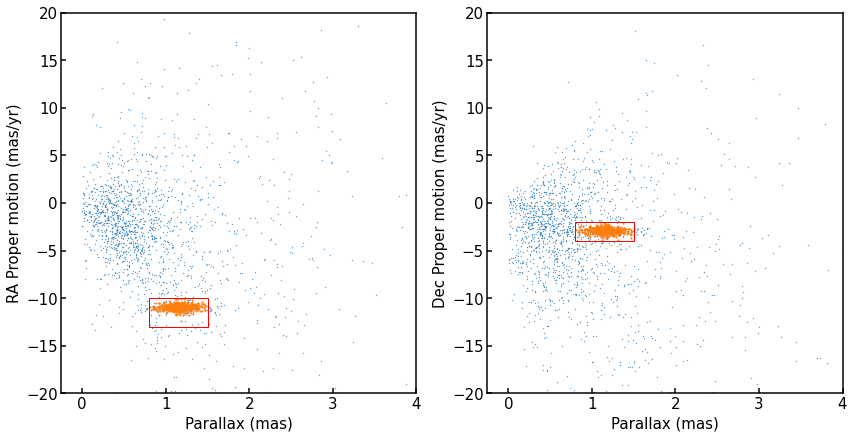

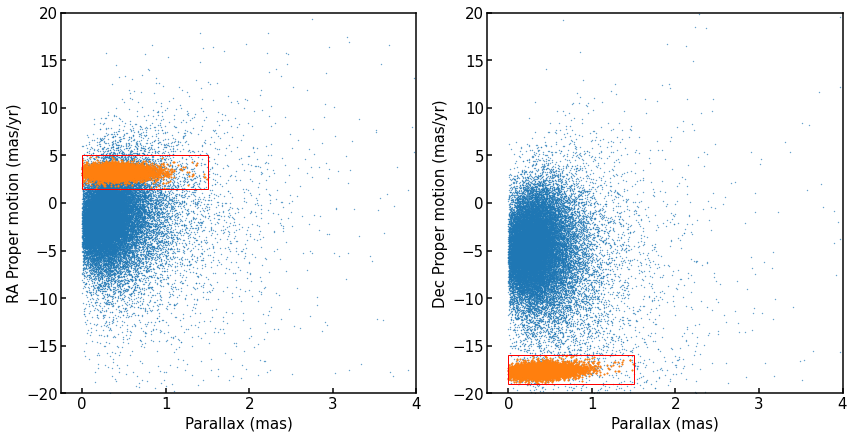

In [51]:
yaxis    = ['pmra','pmdec']
yname    = ['RA Proper motion (mas/yr)','Dec Proper motion (mas/yr)']
axis1 = {'rec_x':[[6.5,8.3],[6.5,8.3]],'rec_y':[[16,23],[-50,-40]],\
        'plot_x':[[-0.25,10],[-0.25,10]],'plot_y':[[-70,30],[-70,30]]}
axis2 = {'rec_x':[[0.8,1.5],[0.8,1.5]],'rec_y':[[-13,-10],[-4,-2]],\
        'plot_x':[[-0.25,4],[-0.25,4]],'plot_y':[[-20,20],[-20,20]]}
axis3 = {'rec_x':[[0,1.5],[0,1.5]],'rec_y':[[1.5,5],[-19,-16]],\
        'plot_x':[[-0.25,4],[-0.25,4]],'plot_y':[[-20,20],[-20,20]]}
axis_arr = [axis1,axis2,axis3]

select_clusters = []
for i in range(3):
    pick = select_member(clusters[i],axis_arr[i],yaxis,yname)
    select_clusters.append(pick)

#### b. Make HR diagrams for each cluster and compare them (overplot in different colors or side-by-side on the same scale
#### c. Plot the absolute magnitude and color you expect for the sum of all the stars in each cluster on your HR diagram.

In [52]:
def sum_mag(arr):
    return -2.5*np.log10(np.sum(10**(-0.4*arr)))

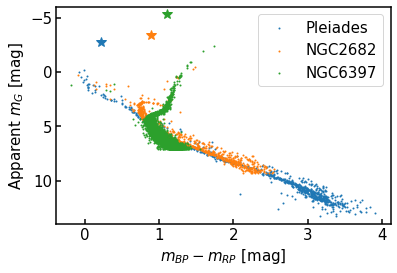

In [53]:
distance = [5.667,9.726,11.92]
names    = ['Pleiades','NGC2682','NGC6397']
color    = ['tab:blue','tab:orange','tab:green']
bp, rp, g = 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'phot_g_mean_mag'
for i,cluster in enumerate(select_clusters):
    plt.scatter(cluster[bp]-cluster[rp],cluster[g]-distance[i],s=1,label=names[i],c=color[i])
    plt.plot(sum_mag(cluster[bp])-sum_mag(cluster[rp]),sum_mag(cluster[g]-distance[i]),markersize=10,marker='*',c=color[i])
plt.ylim([14,-6])
plt.xlabel(r'$m_{BP} - m_{RP}\ [{\rm mag}]$')
plt.ylabel(r'Apparent $m_{G}\ [{\rm mag}]$')
plt.legend()
plt.show()

### Activity 3: 
Forming massive stars: massive stars are particularly important for maintaining the temperature and ionization state of the ISM as well as for providing feedback and heavy elements through supernovae explosions. Assuming a Salpeter IMF, how many stars have to form in order to ensure (you can do this analytically or with Monte Carlo experiments:
#### a. That ~ 10 O & B stars (> ~3 solar masses) form meaning that some of the ISM can be ionized?


In [64]:
salpeter = lambda x:x**(-2.35)
xrange  = np.arange(0.08,100,0.001)
boolean = xrange>3
obrange = xrange[boolean]
pb_all, pb_ob = np.sum(salpeter(xrange)),np.sum(salpeter(obrange))
print(f'One should sample about {int(10/(pb_ob/pb_all))}')

One should sample about 1356


#### b. That a couple of massive (>8 solar mass) stars form ensuring that some core collapse supernovae will go off?

In [68]:
boolean = xrange>8
obrange = xrange[boolean]
pb_all, pb_ob = np.sum(salpeter(xrange)),np.sum(salpeter(obrange))
print(f'One should sample about {int(3/(pb_ob/pb_all))}')

One should sample about 1567


#### c. What are the implications of this for dwarf galaxy formation?

Once the ISM is ionized, there will be some core collapse SNe.